<a href="https://colab.research.google.com/github/Tamid03/Google-Search-Analysis-Projects/blob/main/time_series_forecasting_stock_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# --- SETUP (run once if packages missing) ---
# Uncomment and run the following cell in your environment if needed.
# Note: In some environments, 'prophet' may require build tools. See Prophet docs.
#
# !pip install --upgrade pip
# !pip install pandas numpy matplotlib scikit-learn statsmodels pmdarima prophet tensorflow keras joblib gradio
#
# If installing on Colab, you may need:
# !pip install prophet --no-cache-dir
#
print('Setup cell: uncomment pip installs if running in a fresh environment.')

Setup cell: uncomment pip installs if running in a fresh environment.


In [2]:
# Standard imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# plotting default (do not set global styles so notebook is portable)
%matplotlib inline

print('Imports ready')

Imports ready


In [9]:
# Load dataset (adjust column names if needed)
DATA_PATH = r'/content/yahoo_stock.csv' # Changed path to /content/yahoo_stock.csv
df = pd.read_csv(DATA_PATH, parse_dates=True, infer_datetime_format=True)

# try to detect date column
date_col = None
for c in df.columns:
    if 'date' in c.lower():
        date_col = c
        break

if date_col is None:
    # fallback: assume first column is date-like
    date_col = df.columns[0]

# parse and set index
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.sort_values(date_col).reset_index(drop=True)
df = df.set_index(date_col)

print('Detected date column:', date_col)
print('Dataframe shape:', df.shape)
display(df.head(10))

Detected date column: Date
Dataframe shape: (1825, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
2015-11-28,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
2015-11-29,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
2015-11-30,2093.810059,2080.409912,2090.949951,2080.409912,4.275030e+09,2080.409912
2015-12-01,2103.370117,2082.929932,2082.929932,2102.629883,3.712120e+09,2102.629883


Using column for target (Close price): Close
Time range: 2015-11-23 00:00:00 to 2020-11-20 00:00:00
Number of observations: 1825


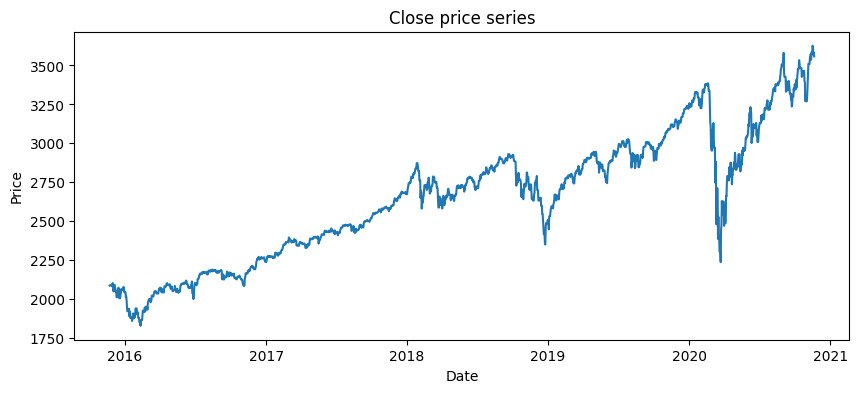

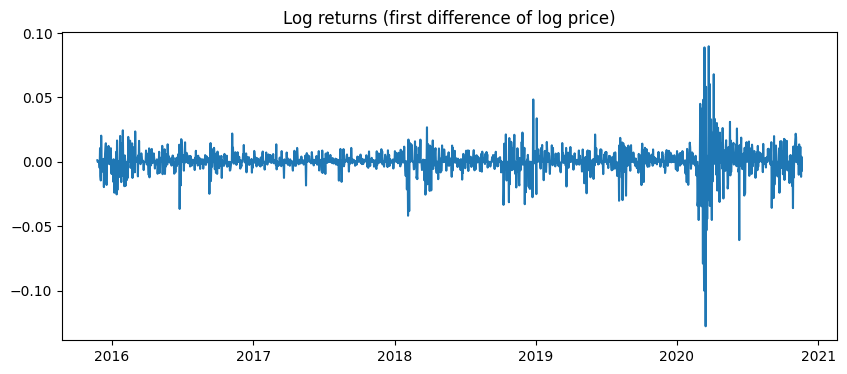

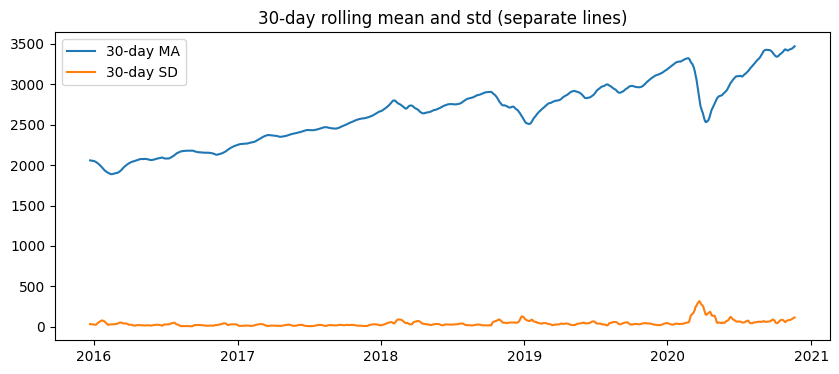

In [10]:
# Basic EDA & plots (adjust 'Close' column if your dataset uses a different column name)
if 'Close' not in df.columns and 'close' in [c.lower() for c in df.columns]:
    # find the real column name
    close_col = [c for c in df.columns if c.lower() == 'close'][0]
else:
    close_col = 'Close' if 'Close' in df.columns else df.columns[0]  # fallback to first numeric column

ts = df[close_col].dropna().astype(float)

print('Using column for target (Close price):', close_col)
print('Time range:', ts.index.min(), 'to', ts.index.max())
print('Number of observations:', len(ts))

# Plot price
plt.figure(figsize=(10,4))
plt.plot(ts)
plt.title('Close price series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Returns
returns = np.log(ts).diff().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.title('Log returns (first difference of log price)')
plt.show()

# Rolling stats
plt.figure(figsize=(10,4))
plt.plot(ts.rolling(30).mean(), label='30-day MA')
plt.plot(ts.rolling(30).std(), label='30-day SD')
plt.title('30-day rolling mean and std (separate lines)')
plt.legend()
plt.show()

In [11]:
# Stationarity test (Augmented Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF test for {title} -- stat: {result[0]:.4f}, p-value: {result[1]:.4f}')
    return result

print('ADF on raw prices:')
adf_test(ts, 'price')

print('\nADF on log-returns:')
adf_test(returns, 'log-returns')

ADF on raw prices:
ADF test for price -- stat: -0.8704, p-value: 0.7976

ADF on log-returns:
ADF test for log-returns -- stat: -8.4389, p-value: 0.0000


(np.float64(-8.438868229137682),
 np.float64(1.7856425238129693e-13),
 24,
 1799,
 {'1%': np.float64(-3.433990164137254),
  '5%': np.float64(-2.8631479299063405),
  '10%': np.float64(-2.567626009684832)},
 np.float64(-11591.971193624844))

In [12]:
# Train / test split (final holdout)
H = 30  # forecast horizon; adjust as needed
train = ts.iloc[:-H]
test = ts.iloc[-H:]
print('Train size:', len(train), 'Test size:', len(test))

Train size: 1795 Test size: 30


In [16]:
# Baseline naive forecast (last value carry-forward)
naive_pred = np.repeat(train.iloc[-1], len(test))
rmse_naive = np.sqrt(mean_squared_error(test, naive_pred))
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Naive RMSE:', rmse_naive)
print('Naive MAPE:', mape(test.values, naive_pred))

Naive RMSE: 117.70220627650048
Naive MAPE: 3.0255568415483363


In [18]:
# ARIMA via pmdarima (auto_arima) and forecast
print('Fitting auto_arima (this may take a while for long series)...')

try:
    import pmdarima as pm
    auto = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, max_p=5, max_q=5, trace=False)
    print(auto.summary())
    arima_fc, confint = auto.predict(n_periods=len(test), return_conf_int=True)
except Exception as e:
    print('pmdarima not installed or failed:', e)
    arima_fc = np.repeat(train.iloc[-1], len(test))

arima_rmse = np.sqrt(mean_squared_error(test, arima_fc))
print('ARIMA RMSE:', arima_rmse)

Fitting auto_arima (this may take a while for long series)...
pmdarima not installed or failed: No module named 'pmdarima'
ARIMA RMSE: 117.70220627650048


In [20]:
# Prophet model (optional)
print('Preparing Prophet forecast...')

try:
    from prophet import Prophet
    prophet_df = train.reset_index().rename(columns={train.index.name or 'index':'ds', train.name or 'Close':'y'})
    prophet_df = prophet_df[['ds', 'y']]
    m = Prophet(daily_seasonality=False)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=len(test), freq='D')
    fcst = m.predict(future)
    prophet_pred = fcst.set_index('ds')['yhat'].iloc[-len(test):].values
    prophet_rmse = np.sqrt(mean_squared_error(test, prophet_pred))
    print('Prophet RMSE:', prophet_rmse)
except Exception as e:
    print('Prophet not installed or failed:', e)
    prophet_pred = np.repeat(train.iloc[-1], len(test))
    prophet_rmse = np.sqrt(mean_squared_error(test, prophet_pred))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmrznq4sm/ilhk1ayn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmrznq4sm/87rcxxgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74299', 'data', 'file=/tmp/tmpmrznq4sm/ilhk1ayn.json', 'init=/tmp/tmpmrznq4sm/87rcxxgd.json', 'output', 'file=/tmp/tmpmrznq4sm/prophet_modelo8596sqt/prophet_model-20251002202235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Preparing Prophet forecast...


20:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 135.28196388931997


In [21]:
# LSTM model (optional - set RUN_LSTM=True to train). Training can be slow on CPU.
RUN_LSTM = False

if RUN_LSTM:
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train.values.reshape(-1,1))
    window = 30

    def make_seq(data, window):
        X,y = [],[]
        for i in range(len(data)-window):
            X.append(data[i:i+window,0])
            y.append(data[i+window,0])
        return np.array(X), np.array(y)

    X_train, y_train = make_seq(scaled_train, window)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([LSTM(64, input_shape=(window,1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

    # iterative forecasting
    last_window = scaler.transform(train.values.reshape(-1,1))[-window:].ravel().tolist()
    preds = []
    for _ in range(len(test)):
        x = np.array(last_window[-window:]).reshape(1,window,1)
        p = model.predict(x)[0,0]
        preds.append(p)
        last_window.append(p)
    lstm_pred = scaler.inverse_transform(np.array(preds).reshape(-1,1)).ravel()
    lstm_rmse = mean_squared_error(test, lstm_pred, squared=False)
    print('LSTM RMSE:', lstm_rmse)
else:
    print('LSTM training skipped. Set RUN_LSTM=True to enable training (may be slow).')

LSTM training skipped. Set RUN_LSTM=True to enable training (may be slow).


In [22]:
# Rolling (walk-forward) evaluation skeleton for a generic model_builder(train_series) -> forecast_array
from sklearn.metrics import mean_squared_error
def rolling_forecast(series, model_builder, h=7, start_train_size=None):
    n = len(series)
    if start_train_size is None:
        start_train_size = int(n*0.5)
    rmses = []
    for split in range(start_train_size, n - h + 1):
        tr = series.iloc[:split]
        te = series.iloc[split:split+h]
        model = model_builder(tr)
        yhat = model.predict(n_periods=h) if hasattr(model, 'predict') else model.forecast(h)
        rmses.append(mean_squared_error(te, yhat, squared=False))
    return np.mean(rmses)

print('Rolling forecast function ready. Example usage for pmdarima auto_arima:')

Rolling forecast function ready. Example usage for pmdarima auto_arima:


In [23]:
try:
    import pmdarima as pm
    def builder_auto(tr):
        return pm.auto_arima(tr, seasonal=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)
    # Warning: the rolling evaluation below can be slow. It's provided as an example and commented out.
    # avg_rmse = rolling_forecast(ts, builder_auto, h=7, start_train_size=100)
    # print('avg rolling RMSE (example):', avg_rmse)
    print('pmdarima builder available for rolling evaluation (example commented out to save time).')
except Exception:
    print('pmdarima not available; skipping rolling example.')

pmdarima not available; skipping rolling example.


,model,RMSE,MAPE
0,Naive,117.702206,3.025557
1,ARIMA,117.702206,3.025557
2,Prophet,135.281964,3.515280



Plot final predictions vs test for best model (by RMSE):
Best model: Naive


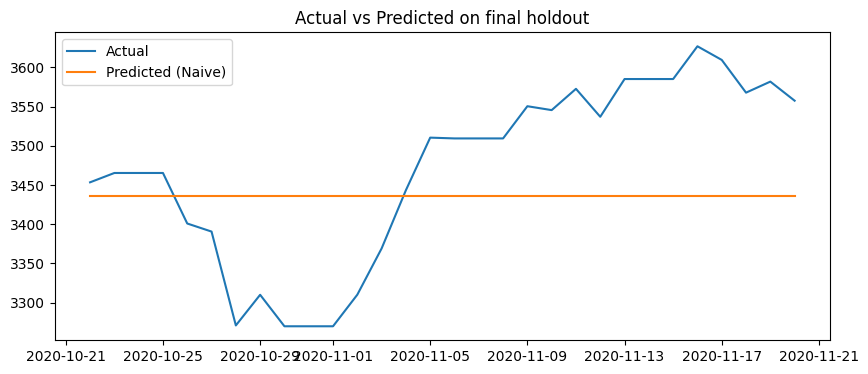

In [25]:
# Compare models on the final holdout
results = []
results.append(('Naive', float(np.sqrt(mean_squared_error(test, naive_pred))), mape(test.values, naive_pred)))
results.append(('ARIMA', float(np.sqrt(mean_squared_error(test, arima_fc))), mape(test.values, arima_fc)))
results.append(('Prophet', float(np.sqrt(mean_squared_error(test, prophet_pred))), mape(test.values, prophet_pred)))
# LSTM included only if trained
try:
    if 'lstm_pred' in globals():
        results.append(('LSTM', float(np.sqrt(mean_squared_error(test, lstm_pred))), mape(test.values, lstm_pred)))
except Exception:
    pass

res_df = pd.DataFrame(results, columns=['model','RMSE','MAPE']).sort_values('RMSE')
display(res_df)
print('\nPlot final predictions vs test for best model (by RMSE):')
best = res_df.iloc[0]['model']
print('Best model:', best)

if best == 'ARIMA':
    best_pred = arima_fc
elif best == 'Prophet':
    best_pred = prophet_pred
elif best == 'LSTM' and 'lstm_pred' in globals():
    best_pred = lstm_pred
else:
    best_pred = naive_pred

plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, best_pred, label=f'Predicted ({best})')
plt.legend()
plt.title('Actual vs Predicted on final holdout')
plt.show()

In [26]:
# Save sample artifacts (models & scaler) - examples
import joblib
try:
    if 'auto' in globals():
        joblib.dump(auto, 'arima_auto_model.pkl')
    if 'scaler' in globals():
        joblib.dump(scaler, 'scaler.pkl')
    # if using keras model: model.save('lstm_model.h5')
    print('Artifacts saved to current working directory (if they were created).')
except Exception as e:
    print('Saving artifacts skipped or failed:', e)

Artifacts saved to current working directory (if they were created).


In [30]:
# Example Gradio app skeleton (save as app.py and deploy to Hugging Face Spaces)
app_code = '''
import gradio as gr
import joblib
import pandas as pd

# Load saved artifacts (ensure these files are present in the Space)
# arima = joblib.load('arima_auto_model.pkl')

def forecast_arima(days=30):
    # placeholder: replace with actual model predict
    return list(range(days))

iface = gr.Interface(
    fn=forecast_arima,
    inputs=gr.Slider(1,90,value=30, label='Days to forecast'),
    outputs='dataframe',
    title='Stock Price Forecast (example)'
)

if __name__ == '__main__':
    iface.launch()
'''
with open('app.py','w') as f:
    f.write(app_code)
print('Example app.py written (edit to load your saved models before deploying).')

Example app.py written (edit to load your saved models before deploying).
